In [ ]:
import numpy as np
import pandas as pd 
import xgboost as xgb
import matplotlib.pyplot as plt
import os 
import gc 
import datetime 


In [ ]:
data_sql  = '''

SELECT a.*
FROM (
    SELECT *
    FROM app_dm.rpt_dc_mirror_uv_hour_model_dateset 
    WHERE  d >= '{0}' AND platname = '汇总' AND productid = 999
) a 
JOIN (
    SELECT MAX(d) AS d 
    FROM app_dm.rpt_dc_mirror_uv_hour_model_dateset 
    WHERE  d >= '{0}'  AND platname = '汇总' AND productid = 999
) b 
ON a.d = b.d

'''.format((datetime.datetime.now() +datetime.timedelta(hours=-3)).strftime("%Y%m%d%H"))


data = spark .sql(data_sql).toPandas()
print(data.shape)


In [28]:
data.head(5)

,intotime,platname,productid,uv,futureintotime,futureuv,intotimechunyun,intotimeholiday,intotimequarter,intotimeworkday,...,houravguv,hourmaxuv,hourminuv,dayofmonthavguv,dayofmonthmaxuv,dayofmonthminuv,weekofyearavguv,weekofyearmaxuv,weekofyearminuv,d
0,2021-10-05 00:00:00,汇总,999,661431,2021-10-05 01:00:00,408706,0,1,4,1,...,482708.333333,523105.0,442933.0,388426,491052,285800,442933,442933,442933,2022030711
1,2021-10-05 01:00:00,汇总,999,408706,2021-10-05 02:00:00,279351,0,1,4,1,...,326958.000000,354543.0,300678.0,257152,317441,196863,300678,300678,300678,2022030711
2,2021-10-05 02:00:00,汇总,999,279351,2021-10-05 03:00:00,211982,0,1,4,1,...,243100.000000,263000.0,225455.0,191131,228277,153985,225455,225455,225455,2022030711
3,2021-10-05 03:00:00,汇总,999,211982,2021-10-05 04:00:00,201619,0,1,4,1,...,231118.000000,251847.0,214993.0,188433,221515,155351,214993,214993,214993,2022030711
4,2021-10-05 04:00:00,汇总,999,201619,2021-10-05 05:00:00,305936,0,1,4,1,...,349649.000000,381865.0,327269.0,297901,345553,250250,327269,327269,327269,2022030711


In [29]:
dataset = data[ data['futureuv'] >= 0]
dataset = dataset.drop(['futureintotime','d','productid','platname'],axis=1)
dataset = dataset.rename(columns={'futureuv': 'label'})


In [30]:
dataset['futuredateweekhour'] = dataset['futuredateweek']*1000*dataset['futurehours']

In [38]:
intotimes = sorted(dataset['intotime'].unique().tolist())

In [39]:
intotimes[(len(intotimes)//100)*95]

'2022-02-04 19:00:00'

In [40]:
intotimes[(len(intotimes)//100)*85]

'2021-12-24 17:00:00'

In [41]:
dftest = dataset[dataset['intotime'] >= intotimes[(len(intotimes)//100)*95]]
dfvalid = dataset[(dataset['intotime'] >=  intotimes[(len(intotimes)//100)*85] ) & (dataset['intotime'] <  intotimes[(len(intotimes)//100)*95] )  ]
dftrain = dataset[dataset['intotime'] < intotimes[(len(intotimes)//100)*85] ]


In [42]:
dftrain = dftrain.drop(['intotime'],axis =1 )
dfvalid = dfvalid.drop(['intotime'],axis =1 )
dftest = dftest.drop(['intotime'],axis =1 )

xgb_train = xgb.DMatrix(dftrain.drop("label",axis = 1),dftrain[["label"]])
xgb_valid = xgb.DMatrix(dfvalid.drop("label",axis = 1),dfvalid[["label"]])
xgb_test = xgb.DMatrix(dftest.drop("label",axis = 1),dftest[["label"]])


In [43]:
dftrain.shape,dfvalid.shape,dftest.shape

((257550, 117), (30300, 117), (17685, 117))

In [45]:
num_boost_round = 1000           
early_stopping_rounds = 10
# 配置xgboost模型参数
params_dict = dict()
# booster参数
params_dict['learning_rate'] = 0.01     # 学习率，通常越小越好。
params_dict['objective'] = 'reg:squarederror'
# tree参数
params_dict['max_depth'] = 8             # 树的深度，通常取值在[3,10]之间
params_dict['min_child_weight']= 2       # 最小叶子节点样本权重和，越大模型越保守。
params_dict['gamma']= 0                   # 节点分裂所需的最小损失函数下降值，越大模型越保守。
params_dict['subsample']= 0.9             # 横向采样，样本采样比例，通常取值在 [0.5，1]之间 
params_dict['colsample_bytree'] = 0.85    # 纵向采样，特征采样比例，通常取值在 [0.5，1]之间 
params_dict['tree_method'] = 'hist'       # 构建树的策略,可以是auto, exact, approx, hist
# regulazation参数 
# Omega(f) = gamma*T + reg_alpha* sum(abs(wj)) + reg_lambda* sum(wj**2)  
params_dict['reg_alpha'] = 0.0            #L1 正则化项的权重系数，越大模型越保守，通常取值在[0,1]之间。
params_dict['reg_lambda'] = 1.0           #L2 正则化项的权重系数，越大模型越保守，通常取值在[1,100]之间。
# 其他参数
params_dict['eval_metric'] = 'mae'
params_dict['seed'] = 1024

result = {}
watchlist = [(xgb_train, 'train'),(xgb_valid,'valid')] 
bst = xgb.train(params = params_dict, dtrain = xgb_train, num_boost_round = num_boost_round, verbose_eval= 1,evals = watchlist,early_stopping_rounds=early_stopping_rounds,evals_result = result)


y_pred_test = bst.predict(xgb_test, ntree_limit=bst.best_iteration)
test_mae = abs(np.array(dftest["label"].values) - y_pred_test)/np.array(dftest["label"].values)
print(np.mean(test_mae),np.max(test_mae),np.min(test_mae))


[0]	train-mae:1044720.56250	valid-mae:1088793.87500
[1]	train-mae:1034282.18750	valid-mae:1078299.25000
[2]	train-mae:1023948.12500	valid-mae:1067675.50000
[3]	train-mae:1013718.00000	valid-mae:1057246.50000
[4]	train-mae:1003590.81250	valid-mae:1046839.87500
[5]	train-mae:993564.87500	valid-mae:1036751.12500
[6]	train-mae:983636.93750	valid-mae:1026712.68750
[7]	train-mae:973809.25000	valid-mae:1016714.12500
[8]	train-mae:964079.62500	valid-mae:1006830.31250
[9]	train-mae:954446.12500	valid-mae:997281.50000
[10]	train-mae:944911.68750	valid-mae:987703.93750
[11]	train-mae:935471.06250	valid-mae:978043.75000
[12]	train-mae:926125.18750	valid-mae:968722.18750
[13]	train-mae:916872.18750	valid-mae:959323.75000
[14]	train-mae:907710.81250	valid-mae:950976.56250
[15]	train-mae:898641.93750	valid-mae:941700.00000
[16]	train-mae:889663.56250	valid-mae:932496.06250
[17]	train-mae:880776.31250	valid-mae:923435.18750
[18]	train-mae:871975.00000	valid-mae:914462.00000
[19]	train-mae:863263.62500

(array([9.41934911, 6.22447304, 4.27542712, 3.28687103, 1.98802683,
        1.18969763, 0.85134326, 0.2120562 , 0.09667268, 0.03118473]),
 array([6.33792374e-06, 3.62709368e-02, 7.25355357e-02, 1.08800135e-01,
        1.45064734e-01, 1.81329332e-01, 2.17593931e-01, 2.53858530e-01,
        2.90123129e-01, 3.26387728e-01, 3.62652327e-01]),
 <BarContainer object of 10 artists>)

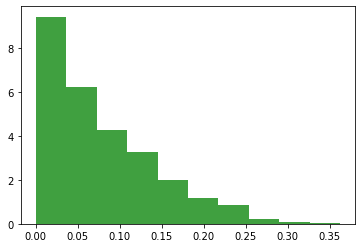

In [46]:
plt.hist(test_mae, 10, density=True, facecolor='g', alpha=0.75)

In [48]:
feature_importants = bst.get_score(importance_type="gain").items()
feature_importants_list = sorted(feature_importants, key=lambda item: item[1], reverse=True) 
print(feature_importants_list)



[('houravguv', 491839301852431.8), ('hourmaxuv', 146042086054935.8), ('hourminuv', 112665296023781.9), ('weekofyearminuv', 8125906014104.787), ('lag12maxuv', 7168480365964.222), ('futurehours', 5679974456551.88), ('intotimeday', 4878933125999.795), ('intotimeholiday', 3779641572507.9976), ('lag7maxuv', 3485478525833.544), ('lag30sumuv', 2949197379661.844), ('weekofyearavguv', 2605763869069.345), ('lag30maxuv', 2587983803810.6997), ('lag7sumuv', 2569893770572.0576), ('lag3maxuv', 2318738292170.834), ('weekofyearmaxuv', 2265709311770.4697), ('lag3minuv', 2245169591253.4136), ('futuredateholiday', 2153396773225.7407), ('lag30minuv', 2137984302214.1455), ('lag7minuv', 2118676335882.1064), ('weekminuv', 2108956893553.8115), ('lag30avguv', 2093372517266.559), ('lag14uv', 2002810317773.4407), ('futuredateday', 1974685594209.597), ('lag3sumuv', 1931940714007.6995), ('lag13uv', 1679222195094.419), ('dayofmonthminuv', 1587099852454.0952), ('lag7avguv', 1497420054710.296), ('futuredateweek', 1407

In [259]:
import datetime
data_sql  = '''

SELECT a.*
FROM (
    SELECT *
    FROM app_dm.rpt_dc_mirror_uv_hour_model_dateset 
    WHERE  d >= '{0}' AND platname = '汇总' AND productid IN (1,2,3,18,23,25) 
    AND futurehoursteps = 30
) a 
JOIN (
    SELECT MAX(d) AS d 
    FROM app_dm.rpt_dc_mirror_uv_hour_model_dateset 
    WHERE  d >= '{0}' AND platname = '汇总' AND productid IN (1,2,3,18,23,25) 
    AND futurehoursteps = 30
) b 
ON a.d = b.d

'''.format((datetime.datetime.now() +datetime.timedelta(hours=-3)).strftime("%Y%m%d%H"))



data = spark .sql(data_sql).toPandas()
print(data.shape)


/usr/local/spark/python/pyspark/sql/dataframe.py:2110: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


(53845, 131)


In [260]:
data.head(5)

,intotime,platname,productid,uv,futureintotime,futureuv,intotimechunyun,intotimeholiday,intotimequarter,intotimeworkday,...,intodayofholiday,intodaysofnextholiday,intoholidaynameid,futuredatedayofholiday,futuredatedaysofnextholiday,futuredateholidaynameid,holidayavguv,holidaymaxuv,holidayminuv,d
0,2021-10-05 00:00:00,汇总,1,212930,2021-10-06 06:00:00,108312,0,1,4,1,...,5,0,4,6,0,4,0.0,0.0,0.0,2022030717
1,2021-10-05 00:00:00,汇总,2,118062,2021-10-06 06:00:00,85611,0,1,4,1,...,5,0,4,6,0,4,0.0,0.0,0.0,2022030717
2,2021-10-05 00:00:00,汇总,3,16187,2021-10-06 06:00:00,10239,0,1,4,1,...,5,0,4,6,0,4,0.0,0.0,0.0,2022030717
3,2021-10-05 00:00:00,汇总,18,315730,2021-10-06 06:00:00,351953,0,1,4,1,...,5,0,4,6,0,4,0.0,0.0,0.0,2022030717
4,2021-10-05 00:00:00,汇总,23,31710,2021-10-06 06:00:00,49521,0,1,4,1,...,5,0,4,6,0,4,0.0,0.0,0.0,2022030717


In [261]:
dataset = data[ data['futureuv'] >= 0]
dataset = dataset.drop(['futureintotime','d','platname','lag31uv',
'lag32uv',
'lag33uv',
'lag34uv',
'lag35uv',
'lag36uv',
'lag37uv',
'lag38uv',
'lag39uv',
'lag40uv',
'lag41uv',
'lag42uv',
'lag43uv',
'lag44uv',
'lag45uv',
'lag46uv',
'lag47uv',
'lag48uv',
'lag49uv',
'lag50uv',
'lag51uv',
'lag52uv',
'lag53uv',
'lag54uv',
'lag55uv',
'lag56uv',
'lag57uv',
'lag58uv',
'lag59uv',
'lag60uv',
'lag30maxuv',
'lag30minuv',
'lag30sumuv',
'lag30avguv',
'lag12maxuv',
'lag12minuv',
'lag12sumuv',
'lag12avguv',
'lag3maxuv',
'lag3minuv',
'lag3sumuv',
'lag3avguv',
'lag7maxuv',
'lag7minuv',
'lag7sumuv',
'lag7avguv'],axis=1)
dataset = dataset.rename(columns={'futureuv': 'label'})
dataset.head(5)

,intotime,productid,uv,label,intotimechunyun,intotimeholiday,intotimequarter,intotimeworkday,futuredatechunyun,futuredateholiday,...,futuredateweekhour,intodayofholiday,intodaysofnextholiday,intoholidaynameid,futuredatedayofholiday,futuredatedaysofnextholiday,futuredateholidaynameid,holidayavguv,holidaymaxuv,holidayminuv
0,2021-10-05 00:00:00,1,212930,108312,0,1,4,1,0,1,...,102,5,0,4,6,0,4,0.0,0.0,0.0
1,2021-10-05 00:00:00,2,118062,85611,0,1,4,1,0,1,...,102,5,0,4,6,0,4,0.0,0.0,0.0
2,2021-10-05 00:00:00,3,16187,10239,0,1,4,1,0,1,...,102,5,0,4,6,0,4,0.0,0.0,0.0
3,2021-10-05 00:00:00,18,315730,351953,0,1,4,1,0,1,...,102,5,0,4,6,0,4,0.0,0.0,0.0
4,2021-10-05 00:00:00,23,31710,49521,0,1,4,1,0,1,...,102,5,0,4,6,0,4,0.0,0.0,0.0


In [262]:
dataset.columns.values

array(['intotime', 'productid', 'uv', 'label', 'intotimechunyun',
       'intotimeholiday', 'intotimequarter', 'intotimeworkday',
       'futuredatechunyun', 'futuredateholiday', 'futuredatequarter',
       'futuredateworkday', 'hours', 'futurehours', 'elongapp', 'tcapp',
       'wechat', 'intotimeweek', 'futuredateweek', 'intotimeday',
       'futuredateday', 'intotimemonth', 'futuredatemonth',
       'intotimeweekofyear', 'futuredateweekofyear', 'intotimedayofyear',
       'futuredatedayofyear', 'intotimeyear', 'futuredateyear',
       'futurehoursteps', 'lag1uv', 'lag2uv', 'lag3uv', 'lag4uv',
       'lag5uv', 'lag6uv', 'lag7uv', 'lag8uv', 'lag9uv', 'lag10uv',
       'lag11uv', 'lag12uv', 'lag13uv', 'lag14uv', 'lag15uv', 'lag16uv',
       'lag17uv', 'lag18uv', 'lag19uv', 'lag20uv', 'lag21uv', 'lag22uv',
       'lag23uv', 'lag24uv', 'lag25uv', 'lag26uv', 'lag27uv', 'lag28uv',
       'lag29uv', 'lag30uv', 'weekavguv', 'weekmaxuv', 'weekminuv',
       'houravguv', 'hourmaxuv', 'hourminu

In [263]:
intotimes = sorted(dataset['intotime'].unique().tolist())

In [264]:
intotimes[(len(intotimes)//10)*9]

'2022-01-20 12:00:00'

In [265]:
dftest = dataset[dataset['intotime'] >= intotimes[(len(intotimes)//100)*95]]
dfvalid = dataset[(dataset['intotime'] >= intotimes[(len(intotimes)//100)*90]) & (dataset['intotime'] < intotimes[(len(intotimes)//100)*95])  ]
dftrain = dataset[dataset['intotime'] < intotimes[(len(intotimes)//100)*90]]

In [266]:
dftest.shape,dfvalid.shape,dftrain.shape

((2750, 82), (2650, 82), (47700, 82))

In [267]:
dftrain = dftrain.drop(['intotime'],axis =1 )
dfvalid = dfvalid.drop(['intotime'],axis =1 )
dftest = dftest.drop(['intotime'],axis =1 )

xgb_train = xgb.DMatrix(dftrain.drop("label",axis = 1),dftrain[["label"]])
xgb_valid = xgb.DMatrix(dfvalid.drop("label",axis = 1),dfvalid[["label"]])
xgb_test = xgb.DMatrix(dftest.drop("label",axis = 1),dftest[["label"]])



In [268]:
gc.collect()


num_boost_round = 1000           
early_stopping_rounds = 10
# 配置xgboost模型参数
params_dict = dict()
# booster参数
params_dict['learning_rate'] = 0.01     # 学习率，通常越小越好。
params_dict['objective'] = 'reg:squarederror'
# tree参数
params_dict['max_depth'] = 8             # 树的深度，通常取值在[3,10]之间
params_dict['min_child_weight']= 2       # 最小叶子节点样本权重和，越大模型越保守。
params_dict['gamma']= 0                   # 节点分裂所需的最小损失函数下降值，越大模型越保守。
params_dict['subsample']= 0.9             # 横向采样，样本采样比例，通常取值在 [0.5，1]之间 
params_dict['colsample_bytree'] = 0.85    # 纵向采样，特征采样比例，通常取值在 [0.5，1]之间 
params_dict['tree_method'] = 'hist'       # 构建树的策略,可以是auto, exact, approx, hist
# regulazation参数 
# Omega(f) = gamma*T + reg_alpha* sum(abs(wj)) + reg_lambda* sum(wj**2)  
params_dict['reg_alpha'] = 0.0            #L1 正则化项的权重系数，越大模型越保守，通常取值在[0,1]之间。
params_dict['reg_lambda'] = 1.0           #L2 正则化项的权重系数，越大模型越保守，通常取值在[1,100]之间。
# 其他参数
params_dict['eval_metric'] = 'mae'
params_dict['seed'] = 1024

result = {}
watchlist = [(xgb_train, 'train'),(xgb_valid,'valid')] 
bst = xgb.train(params = params_dict, dtrain = xgb_train, num_boost_round = num_boost_round, verbose_eval= 1,evals = watchlist,early_stopping_rounds=early_stopping_rounds,evals_result = result)

print("best_iteration: ".format(str(bst.best_iteration)))


[0]	train-mae:206947.60938	valid-mae:210412.57812
[1]	train-mae:204886.32812	valid-mae:208322.35938
[2]	train-mae:202845.35938	valid-mae:206286.06250
[3]	train-mae:200825.76562	valid-mae:204203.25000
[4]	train-mae:198826.57812	valid-mae:202187.21875
[5]	train-mae:196846.59375	valid-mae:200181.68750
[6]	train-mae:194888.64062	valid-mae:198173.10938
[7]	train-mae:192947.51562	valid-mae:196192.43750
[8]	train-mae:191025.64062	valid-mae:194257.98438
[9]	train-mae:189124.87500	valid-mae:192355.54688
[10]	train-mae:187241.59375	valid-mae:190438.56250
[11]	train-mae:185379.07812	valid-mae:188527.43750
[12]	train-mae:183535.53125	valid-mae:186650.76562
[13]	train-mae:181709.92188	valid-mae:184796.85938
[14]	train-mae:179903.67188	valid-mae:182957.18750
[15]	train-mae:178114.01562	valid-mae:181153.51562
[16]	train-mae:176341.96875	valid-mae:179347.84375
[17]	train-mae:174589.20312	valid-mae:177562.51562
[18]	train-mae:172854.12500	valid-mae:175812.48438
[19]	train-mae:171135.06250	valid-mae:174

In [269]:
bst.best_iteration

356

In [270]:
y_pred_test = bst.predict(xgb_test, ntree_limit=bst.best_iteration)
test_mae = abs(np.array(dftest["label"].values) - y_pred_test)/np.array(dftest["label"].values)
print(np.mean(test_mae),np.max(test_mae),np.min(test_mae))
#0.15106993166107976 5.491317712490024 9.272776907373119e-08

0.10713416371940081 1.0375536652325468 6.727104931114446e-06


In [271]:
feature_importants = bst.get_score(importance_type="gain").items()
feature_importants_list = sorted(feature_importants, key=lambda item: item[1], reverse=True) 
print(feature_importants_list)


[('lag18uv', 23988160938173.16), ('houravguv', 16445463349378.354), ('hourminuv', 1636875838250.5115), ('hourmaxuv', 1222314085553.1296), ('lag17uv', 782309118767.1519), ('uv', 446851764453.6432), ('intotimeyear', 419170425465.9085), ('futuredateyear', 285139383943.04346), ('futuredateday', 211621235234.48666), ('hours', 195441371292.10992), ('lag19uv', 161712792563.25055), ('lag1uv', 148822596213.82916), ('lag2uv', 108065640387.1054), ('productid', 103029901172.21521), ('weekofyearminuv', 90162107321.79474), ('futuredatedayofholiday', 85506014798.54372), ('futuredateworkday', 84794008559.80101), ('intotimeholiday', 78544693326.0), ('futuredateholiday', 75806848141.06346), ('intotimemonth', 74981715907.83981), ('lag21uv', 73975801371.38298), ('dayofmonthminuv', 71783770003.21655), ('futuredatedaysofnextholiday', 67077483328.878296), ('futuredatedayofyear', 63997521963.20372), ('intodaysofnextholiday', 63844471963.27737), ('lag10uv', 63488373060.94971), ('lag3uv', 61631934835.636696), (

(array([6.28405305e+00, 1.96267134e+00, 8.02592386e-01, 2.55848228e-01,
        1.75238512e-01, 7.36001751e-02, 5.25715537e-02, 2.10286215e-02,
        7.00954049e-03, 3.50477024e-03]),
 array([6.72710493e-06, 1.03761421e-01, 2.07516115e-01, 3.11270809e-01,
        4.15025502e-01, 5.18780196e-01, 6.22534890e-01, 7.26289584e-01,
        8.30044278e-01, 9.33798971e-01, 1.03755367e+00]),
 <BarContainer object of 10 artists>)

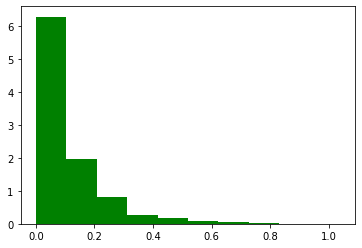

In [272]:
plt.hist(test_mae, 10, density=True, facecolor='g')

In [273]:
y_pred_test_df = pd.DataFrame(y_pred_test,columns=["pred"])

In [274]:
len(y_pred_test_df)

2750

In [275]:
test_dataset = data[(data['intotime'] >= intotimes[(len(intotimes)//100)*95]) & (data['futureuv'] >= 0 )]
test_dataset.reset_index(inplace=True,drop =True)
test_dataset.head(5)

,intotime,platname,productid,uv,futureintotime,futureuv,intotimechunyun,intotimeholiday,intotimequarter,intotimeworkday,...,intodayofholiday,intodaysofnextholiday,intoholidaynameid,futuredatedayofholiday,futuredatedaysofnextholiday,futuredateholidaynameid,holidayavguv,holidaymaxuv,holidayminuv,d
0,2022-02-10 20:00:00,汇总,1,332254,2022-02-12 02:00:00,86728,1,0,1,1,...,0,52,0,0,50,0,0.0,0.0,0.0,2022030717
1,2022-02-10 20:00:00,汇总,2,398683,2022-02-12 02:00:00,61372,1,0,1,1,...,0,52,0,0,50,0,0.0,0.0,0.0,2022030717
2,2022-02-10 20:00:00,汇总,3,15254,2022-02-12 02:00:00,2418,1,0,1,1,...,0,52,0,0,50,0,0.0,0.0,0.0,2022030717
3,2022-02-10 20:00:00,汇总,18,929170,2022-02-12 02:00:00,124933,1,0,1,1,...,0,52,0,0,50,0,0.0,0.0,0.0,2022030717
4,2022-02-10 20:00:00,汇总,23,68120,2022-02-12 02:00:00,9167,1,0,1,1,...,0,52,0,0,50,0,0.0,0.0,0.0,2022030717


In [276]:
test_dataset = test_dataset.drop(['platname','d'],axis = 1 )

In [277]:

dftest_df = test_dataset.join(y_pred_test_df)
dftest_df.head(5)

,intotime,productid,uv,futureintotime,futureuv,intotimechunyun,intotimeholiday,intotimequarter,intotimeworkday,futuredatechunyun,...,intodayofholiday,intodaysofnextholiday,intoholidaynameid,futuredatedayofholiday,futuredatedaysofnextholiday,futuredateholidaynameid,holidayavguv,holidaymaxuv,holidayminuv,pred
0,2022-02-10 20:00:00,1,332254,2022-02-12 02:00:00,86728,1,0,1,1,1,...,0,52,0,0,50,0,0.0,0.0,0.0,81092.554688
1,2022-02-10 20:00:00,2,398683,2022-02-12 02:00:00,61372,1,0,1,1,1,...,0,52,0,0,50,0,0.0,0.0,0.0,61186.058594
2,2022-02-10 20:00:00,3,15254,2022-02-12 02:00:00,2418,1,0,1,1,1,...,0,52,0,0,50,0,0.0,0.0,0.0,2737.998779
3,2022-02-10 20:00:00,18,929170,2022-02-12 02:00:00,124933,1,0,1,1,1,...,0,52,0,0,50,0,0.0,0.0,0.0,126071.156250
4,2022-02-10 20:00:00,23,68120,2022-02-12 02:00:00,9167,1,0,1,1,1,...,0,52,0,0,50,0,0.0,0.0,0.0,10648.117188


In [278]:
dftest_df.to_csv('./dftest.csv',index = False)

In [235]:
gc.collect()

185

In [183]:
data_sql = ''' 

SELECT *
FROM tmp_dm.tmp_ybl_rpt_dc_mirror_pv_day_all_dataset

'''
data = spark .sql(data_sql).toPandas()
print(data.shape)


/usr/local/spark/python/pyspark/sql/dataframe.py:2110: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


(16254, 118)


In [184]:
dataset = data[ data['futuredateuv'] > 0]
dataset = dataset.drop(['futuredate'],axis=1)
dataset = dataset.rename(columns={'futuredateuv': 'label'})
intotimes = sorted(dataset['intotime'].unique().tolist(),reverse=True)

dftest = dataset[dataset['intotime'] >= intotimes[50]]
dfvalid = dataset[(dataset['intotime'] >= intotimes[100]) & (dataset['intotime'] < intotimes[50])  ]
dftrain = dataset[dataset['intotime'] < intotimes[100]]



In [185]:
dataset[(dataset['intotime'] == '2022-03-05')   ]

,intotime,uv,intotimechunyun,intotimeholiday,intotimequarter,intotimeworkday,label,futuredatechunyun,futuredateholiday,futuredatequarter,...,dayminuv,monthavguv,monthmaxuv,monthminuv,weekofyearavguv,weekofyearmaxuv,weekofyearminuv,holidayavguv,holidaymaxuv,holidayminuv
681,2022-03-05,15635616,0,0,1,0,15129316,0,0,1,...,18844676,1.315593e+07,20352569,7622301,1.440498e+07,20352569,8465233,0.0,0,0


In [186]:
intotimes[0]

'2022-03-05'

In [187]:
intotimes[100]

'2021-11-25'

In [188]:
dftrain = dftrain.drop(['intotime'],axis =1 )
dfvalid = dfvalid.drop(['intotime'],axis =1 )
dftest = dftest.drop(['intotime'],axis =1 )

xgb_train = xgb.DMatrix(dftrain.drop("label",axis = 1),dftrain[["label"]])
xgb_valid = xgb.DMatrix(dfvalid.drop("label",axis = 1),dfvalid[["label"]])
xgb_test = xgb.DMatrix(dftest.drop("label",axis = 1),dftest[["label"]])


In [205]:
gc.collect()


num_boost_round = 1000           
early_stopping_rounds = 10
# 配置xgboost模型参数
params_dict = dict()
# booster参数
params_dict['learning_rate'] = 0.01     # 学习率，通常越小越好。
params_dict['objective'] = 'reg:squarederror'
# tree参数
params_dict['max_depth'] = 10            # 树的深度，通常取值在[3,10]之间
params_dict['min_child_weight']= 2       # 最小叶子节点样本权重和，越大模型越保守。
params_dict['gamma']= 0                   # 节点分裂所需的最小损失函数下降值，越大模型越保守。
params_dict['subsample']= 0.9             # 横向采样，样本采样比例，通常取值在 [0.5，1]之间 
params_dict['colsample_bytree'] = 0.85    # 纵向采样，特征采样比例，通常取值在 [0.5，1]之间 
params_dict['tree_method'] = 'hist'       # 构建树的策略,可以是auto, exact, approx, hist
# regulazation参数 
# Omega(f) = gamma*T + reg_alpha* sum(abs(wj)) + reg_lambda* sum(wj**2)  
params_dict['reg_alpha'] = 0.0            #L1 正则化项的权重系数，越大模型越保守，通常取值在[0,1]之间。
params_dict['reg_lambda'] = 1.0           #L2 正则化项的权重系数，越大模型越保守，通常取值在[1,100]之间。
# 其他参数
params_dict['eval_metric'] = 'rmse'
params_dict['seed'] = 1024

result = {}
watchlist = [(xgb_train, 'train'),(xgb_valid,'valid')] 
bst = xgb.train(params = params_dict, dtrain = xgb_train, num_boost_round = num_boost_round, verbose_eval= 1,evals = watchlist,early_stopping_rounds=early_stopping_rounds,evals_result = result)


y_pred_test = bst.predict(xgb_test, ntree_limit=bst.best_iteration)
test_mae = abs(np.array(dftest["label"].values) - y_pred_test)/np.array(dftest["label"].values)
print(np.mean(test_mae),np.max(test_mae),np.min(test_mae))


[0]	train-rmse:15694381.00000	valid-rmse:16880828.00000
[1]	train-rmse:15539018.00000	valid-rmse:16712624.00000
[2]	train-rmse:15385429.00000	valid-rmse:16546508.00000
[3]	train-rmse:15233248.00000	valid-rmse:16371247.00000
[4]	train-rmse:15082785.00000	valid-rmse:16203178.00000
[5]	train-rmse:14933521.00000	valid-rmse:16037219.00000
[6]	train-rmse:14785848.00000	valid-rmse:15871784.00000
[7]	train-rmse:14639647.00000	valid-rmse:15710335.00000
[8]	train-rmse:14494942.00000	valid-rmse:15551573.00000
[9]	train-rmse:14351647.00000	valid-rmse:15394575.00000
[10]	train-rmse:14209764.00000	valid-rmse:15238221.00000
[11]	train-rmse:14069204.00000	valid-rmse:15077410.00000
[12]	train-rmse:13930084.00000	valid-rmse:14925265.00000
[13]	train-rmse:13792534.00000	valid-rmse:14779211.00000
[14]	train-rmse:13656111.00000	valid-rmse:14633389.00000
[15]	train-rmse:13521169.00000	valid-rmse:14488063.00000
[16]	train-rmse:13387632.00000	valid-rmse:14341581.00000
[17]	train-rmse:13255548.00000	valid-rmse

In [206]:
#0.1334164129709812 0.4142326055162067 5.4899233127098054e-05  reg:squarederror mae 
feature_importants = bst.get_score(importance_type="gain").items()
feature_importants_list = sorted(feature_importants, key=lambda item: item[1], reverse=True) 
print(feature_importants_list)



[('lag1uv', 3601162712939584.5), ('uv', 2860189317415918.5), ('lagminuvin7d', 1136017372552582.0), ('lagminuvin14d', 470154172198714.44), ('lag28uv', 341875888880441.94), ('lag27uv', 282657904436906.94), ('monthminuv', 224452821769416.56), ('lagmaxuvin30d', 207717070642248.94), ('weekofyearmaxuv', 200195908622894.38), ('lagavguvin14d', 196427990640000.0), ('lag366uv', 174901615107322.97), ('lag29uv', 167517765513841.88), ('lag363uv', 167432322971707.75), ('intotimemonth', 166764162907816.03), ('lag364uv', 131875480143153.88), ('lag5uvsub', 130545780626781.48), ('lag362uv', 124039378888693.17), ('lag2uv', 116711907466403.45), ('lag365uv', 113405578380850.34), ('lag30uv', 105614512015481.6), ('intotimeweekofyear', 105002114405773.02), ('lag353uv', 104719114703775.44), ('futuredatequarter', 104598265222978.53), ('futuredatedaysofnextholiday', 103103637461615.12), ('lag4uvsub', 96735579663620.52), ('futuredatedayofyear', 92741773425753.31), ('weekofyearminuv', 89396123415394.9), ('lagavguv

In [199]:
test_dateset = data[ (data['intotime'] >= intotimes[50]) &  (data['futuredateuv'] > 0)]
test_dateset.reset_index(inplace=True,drop =True)

In [200]:
y_pred_test_df = pd.DataFrame(y_pred_test,columns=["pred"])
y_pred_test_df.head(5)

,pred
0,18739882.0
1,13442413.0
2,13540290.0
3,18041082.0
4,18378358.0


In [201]:
test_dateset.head(5)

,intotime,uv,intotimechunyun,intotimeholiday,intotimequarter,intotimeworkday,futuredate,futuredateuv,futuredatechunyun,futuredateholiday,...,dayminuv,monthavguv,monthmaxuv,monthminuv,weekofyearavguv,weekofyearmaxuv,weekofyearminuv,holidayavguv,holidaymaxuv,holidayminuv
0,2022-02-16,21558305,1,0,1,1,2022-02-17,20603313,1,0,...,15895241,1.358603e+07,22554521,6560699,1.355710e+07,20823100,6560699,0.0,0,0
1,2022-03-04,15935051,0,0,1,1,2022-03-05,15635616,0,0,...,18590726,1.311317e+07,20352569,7622301,1.431997e+07,20352569,8465233,0.0,0,0
2,2022-02-01,15248001,1,1,1,1,2022-02-02,17457575,1,1,...,15963903,1.188612e+07,20549094,6560699,1.228195e+07,14223048,9204084,13774188.0,14160245,13388131
3,2022-02-20,18882260,1,0,1,0,2022-02-21,17963772,1,0,...,15490743,1.395823e+07,22554521,6560699,1.390167e+07,20549094,7265631,0.0,0,0
4,2022-02-14,20823100,1,0,1,1,2022-02-15,20500772,1,0,...,15119395,1.338386e+07,22554521,6560699,1.254212e+07,20060757,6560699,0.0,0,0


In [202]:
test_uv =  test_dateset.join(y_pred_test_df)
test_uv.to_csv('test_uv.csv',index =False)

In [195]:
import lightgbm as lgb
params = {
    "feature_pre_filter": False
}

train_set = lgb.Dataset(dftrain.drop("label",axis = 1), label=dftrain[["label"]], params=params)
test_set = lgb.Dataset(dftest.drop("label",axis = 1), label=dftest[["label"]], reference=train_set)

In [196]:
params = {
    'objective':'regression' #设置目标函数为regression，将会使用最小均方误差(MSE)作为目标函数。其他超参数保持默认。
}
model = lgb.train(params=params, train_set=train_set, valid_sets=[test_set], valid_names=["test"])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22360
[LightGBM] [Info] Number of data points in the train set: 14826, number of used features: 115
[LightGBM] [Info] Start training from score 15351642.857750


/home/data_ming/.local/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


[1]	test's l2: 1.15448e+13
[2]	test's l2: 1.07404e+13
[3]	test's l2: 1.01978e+13
[4]	test's l2: 9.49628e+12
[5]	test's l2: 9.28988e+12
[6]	test's l2: 8.89693e+12
[7]	test's l2: 8.51977e+12
[8]	test's l2: 8.61558e+12
[9]	test's l2: 8.56182e+12
[10]	test's l2: 8.46577e+12
[11]	test's l2: 8.23086e+12
[12]	test's l2: 8.26151e+12
[13]	test's l2: 7.86889e+12
[14]	test's l2: 7.87214e+12
[15]	test's l2: 7.71246e+12
[16]	test's l2: 7.54858e+12
[17]	test's l2: 7.63674e+12
[18]	test's l2: 7.63574e+12
[19]	test's l2: 7.60519e+12
[20]	test's l2: 7.6264e+12
[21]	test's l2: 7.5506e+12
[22]	test's l2: 7.47321e+12
[23]	test's l2: 7.42566e+12
[24]	test's l2: 7.31946e+12
[25]	test's l2: 7.38877e+12
[26]	test's l2: 7.35132e+12
[27]	test's l2: 7.42259e+12
[28]	test's l2: 7.46596e+12
[29]	test's l2: 7.4145e+12
[30]	test's l2: 7.24764e+12
[31]	test's l2: 7.19496e+12
[32]	test's l2: 7.13641e+12
[33]	test's l2: 7.11864e+12
[34]	test's l2: 7.09616e+12
[35]	test's l2: 7.03603e+12
[36]	test's l2: 7.03309e+12
[37]